STEP 2: TESTING ML-BASED SCORING WEIGHTS
✅ RELIANCE: 494 rows
✅ TCS: 494 rows
✅ HDFCBANK: 494 rows
✅ INFY: 494 rows
✅ KOTAKBANK: 494 rows

✅ ML weights loaded:
  MACD: 34.2%
  RSI: 32.9%
  BB: 31.3%
  Supertrend: 1.6%

SCORE COMPARISON - OLD vs NEW WEIGHTS

RELIANCE:
  RSI: 30.0 | MACD: 75.0 | BB: 87.0 | ST: 70.0
  OLD SCORE (25% each): 65.5
  NEW SCORE (ML weights): 63.9
  Difference: -1.6
  OLD SIGNAL: 🟢 BUY
  NEW SIGNAL: 🟢 BUY

TCS:
  RSI: 40.0 | MACD: 75.0 | BB: 100.0 | ST: 70.0
  OLD SCORE (25% each): 71.2
  NEW SCORE (ML weights): 71.2
  Difference: -0.0
  OLD SIGNAL: 🟢 BUY
  NEW SIGNAL: 🟢 BUY

HDFCBANK:
  RSI: 50.0 | MACD: 25.0 | BB: 49.0 | ST: 70.0
  OLD SCORE (25% each): 48.5
  NEW SCORE (ML weights): 41.4
  Difference: -7.1
  OLD SIGNAL: 🟡 HOLD
  NEW SIGNAL: 🔴 SELL

INFY:
  RSI: 40.0 | MACD: 75.0 | BB: 100.0 | ST: 70.0
  OLD SCORE (25% each): 71.2
  NEW SCORE (ML weights): 71.2
  Difference: -0.0
  OLD SIGNAL: 🟢 BUY
  NEW SIGNAL: 🟢 BUY

KOTAKBANK:
  RSI: 60.0 | MACD: 25.0 | B

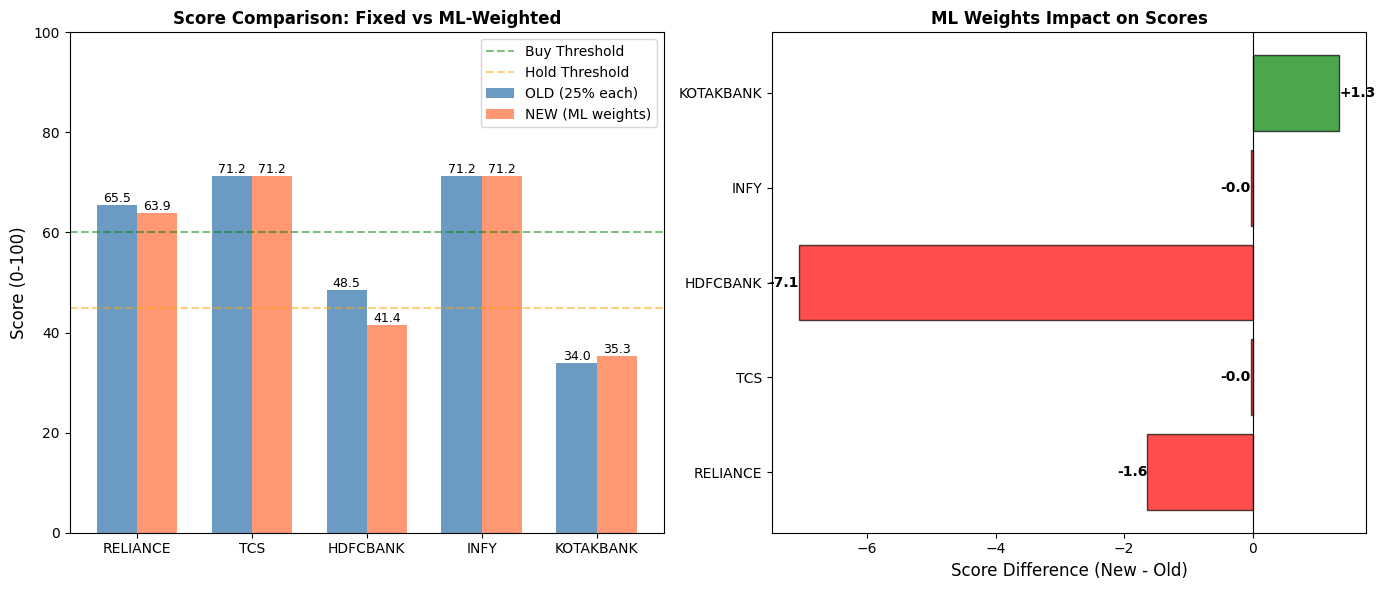


KEY FINDINGS

Which stocks changed their signal?
  HDFCBANK: 🟡 HOLD → 🔴 SELL

Average score change: -1.5
Biggest improvement: KOTAKBANK (+1.3)
Biggest decline: HDFCBANK (-7.1)

Final Scores:
    Stock  Old_Score  New_Score Old_Signal New_Signal
 RELIANCE      65.50    63.8627      🟢 BUY      🟢 BUY
      TCS      71.25    71.2175      🟢 BUY      🟢 BUY
 HDFCBANK      48.50    41.4409     🟡 HOLD     🔴 SELL
     INFY      71.25    71.2175      🟢 BUY      🟢 BUY
KOTAKBANK      34.00    35.3471     🔴 SELL     🔴 SELL

✅ STEP 2 COMPLETE: ML-weighted scores tested vs fixed weights


In [ ]:
# %% [markdown]
# # STEP 2: Testing ML-Based Scoring Weights

# %%
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

# ==================== Setup (Jupyter Compatible) ====================

# ✅ Use current working directory instead of __file__
notebooks_dir = Path.cwd()
project_root = notebooks_dir.parent
src_dir = project_root / 'src'

sys.path.insert(0, str(src_dir))

from nse_analyzer.utils.config import ConfigManager

config_manager = ConfigManager()
data_dir = config_manager.get_data_dir()
indicators_dir = data_dir / "indicators"
output_dir = notebooks_dir

stocks = ["RELIANCE", "TCS", "HDFCBANK", "INFY", "KOTAKBANK"]

print("="*80)
print("STEP 2: TESTING ML-BASED SCORING WEIGHTS")
print("="*80)

# ==================== Load Data ====================

# %%
def load_indicator_data(stock_name):
    csv_path = indicators_dir / f"{stock_name}_indicators.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df['Date'] = pd.to_datetime(df['Date'])
        return df.sort_values('Date').reset_index(drop=True)
    return None

data = {}
for stock in stocks:
    df = load_indicator_data(stock)
    if df is not None:
        data[stock] = df
        print(f"✅ {stock}: {len(df)} rows")

# ==================== Load ML Weights ====================

# %%
weights_file = output_dir / "ml_backtest_results.json"

if weights_file.exists():
    with open(weights_file, 'r') as f:
        ml_results = json.load(f)
    ml_weights = ml_results['normalized_weights']
    print(f"\n✅ ML weights loaded:")
    for indicator, weight in sorted(ml_weights.items(), key=lambda x: x[1], reverse=True):
        print(f"  {indicator}: {weight*100:.1f}%")
else:
    print(f"❌ ML weights file not found at: {weights_file}")
    print("Run step 1 first!")
    # Use default weights if file doesn't exist
    ml_weights = {
        'MACD': 0.342,
        'RSI': 0.329,
        'BB': 0.313,
        'Supertrend': 0.016
    }
    print("Using default ML weights for now...")

# ==================== Define Scoring Functions ====================

# %%
def calculate_indicator_scores(df):
    """Extract raw indicator values for a single row."""
    latest = df.iloc[-1]
    
    # 1. RSI Score (0-100)
    rsi = latest['RSI_14']
    if rsi >= 70:
        rsi_score = 30
    elif rsi >= 60:
        rsi_score = 40
    elif rsi > 50:
        rsi_score = 50
    elif rsi > 40:
        rsi_score = 60
    elif rsi <= 30:
        rsi_score = 70
    else:
        rsi_score = 50
    
    # 2. MACD Score (0-100)
    histogram = latest['MACD_Histogram']
    macd_line = latest['MACD']
    signal_line = latest['MACD_Signal']
    
    if histogram > 0 and macd_line > signal_line:
        macd_score = 75
    elif histogram > 0:
        macd_score = 60
    elif histogram < 0 and macd_line < signal_line:
        macd_score = 25
    elif histogram < 0:
        macd_score = 40
    else:
        macd_score = 50
    
    # 3. BB Score (0-100)
    close = latest['Close']
    upper = latest['BB_Upper_20']
    lower = latest['BB_Lower_20']
    
    bb_percent = (close - lower) / (upper - lower) if (upper - lower) > 0 else 0.5
    bb_score = int(bb_percent * 100)
    bb_score = max(0, min(100, bb_score))
    
    # 4. Supertrend Score (0-100)
    if latest['Supertrend_Direction'] > 0:
        supertrend_score = 70
    else:
        supertrend_score = 30
    
    return {
        'RSI': rsi_score,
        'MACD': macd_score,
        'BB': bb_score,
        'Supertrend': supertrend_score
    }

def calculate_composite_score(ind_scores, weights):
    """Calculate composite score using given weights."""
    return (
        ind_scores['RSI'] * weights['RSI'] +
        ind_scores['MACD'] * weights['MACD'] +
        ind_scores['BB'] * weights['BB'] +
        ind_scores['Supertrend'] * weights['Supertrend']
    )

# ==================== Calculate Scores ====================

# %%
# Old weights (fixed 25%)
old_weights = {
    'RSI': 0.25,
    'MACD': 0.25,
    'BB': 0.25,
    'Supertrend': 0.25
}

print("\n" + "="*80)
print("SCORE COMPARISON - OLD vs NEW WEIGHTS")
print("="*80)

results_comparison = []

for stock in stocks:
    if stock not in data:
        continue
    
    df = data[stock]
    ind_scores = calculate_indicator_scores(df)
    
    old_score = calculate_composite_score(ind_scores, old_weights)
    new_score = calculate_composite_score(ind_scores, ml_weights)
    
    print(f"\n{stock}:")
    print(f"  RSI: {ind_scores['RSI']:.1f} | MACD: {ind_scores['MACD']:.1f} | BB: {ind_scores['BB']:.1f} | ST: {ind_scores['Supertrend']:.1f}")
    print(f"  OLD SCORE (25% each): {old_score:.1f}")
    print(f"  NEW SCORE (ML weights): {new_score:.1f}")
    print(f"  Difference: {new_score - old_score:+.1f}")
    
    # Determine signal
    old_signal = "🟢 BUY" if old_score >= 60 else "🟡 HOLD" if old_score >= 45 else "🔴 SELL"
    new_signal = "🟢 BUY" if new_score >= 60 else "🟡 HOLD" if new_score >= 45 else "🔴 SELL"
    
    print(f"  OLD SIGNAL: {old_signal}")
    print(f"  NEW SIGNAL: {new_signal}")
    
    results_comparison.append({
        'Stock': stock,
        'Old_Score': old_score,
        'New_Score': new_score,
        'Old_Signal': old_signal,
        'New_Signal': new_signal,
        'Difference': new_score - old_score
    })

# ==================== Visualization ====================

# %%
comp_df = pd.DataFrame(results_comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Score Comparison
ax1 = axes[0]
x = np.arange(len(comp_df))
width = 0.35

bars1 = ax1.bar(x - width/2, comp_df['Old_Score'], width, label='OLD (25% each)', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, comp_df['New_Score'], width, label='NEW (ML weights)', alpha=0.8, color='coral')

ax1.set_ylabel('Score (0-100)', fontsize=12)
ax1.set_title('Score Comparison: Fixed vs ML-Weighted', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['Stock'])
ax1.axhline(y=60, color='green', linestyle='--', alpha=0.5, label='Buy Threshold')
ax1.axhline(y=45, color='orange', linestyle='--', alpha=0.5, label='Hold Threshold')
ax1.legend()
ax1.set_ylim([0, 100])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Score Differences
ax2 = axes[1]
colors = ['green' if x > 0 else 'red' for x in comp_df['Difference']]
bars = ax2.barh(comp_df['Stock'], comp_df['Difference'], color=colors, alpha=0.7, edgecolor='black')

ax2.set_xlabel('Score Difference (New - Old)', fontsize=12)
ax2.set_title('ML Weights Impact on Scores', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:+.1f}', ha='left' if width > 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / "images" / "step2_score_comparison.png", dpi=300, bbox_inches='tight')
print("\n✅ Comparison visualization saved!")
plt.show()

# ==================== Summary ====================

# %%
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\nWhich stocks changed their signal?")
signal_changes = comp_df[comp_df['Old_Signal'] != comp_df['New_Signal']]
if len(signal_changes) > 0:
    for idx, row in signal_changes.iterrows():
        print(f"  {row['Stock']}: {row['Old_Signal']} → {row['New_Signal']}")
else:
    print("  None - all signals remained the same!")

print(f"\nAverage score change: {comp_df['Difference'].mean():+.1f}")
print(f"Biggest improvement: {comp_df.loc[comp_df['Difference'].idxmax(), 'Stock']} ({comp_df['Difference'].max():+.1f})")
print(f"Biggest decline: {comp_df.loc[comp_df['Difference'].idxmin(), 'Stock']} ({comp_df['Difference'].min():+.1f})")

print("\nFinal Scores:")
print(comp_df[['Stock', 'Old_Score', 'New_Score', 'Old_Signal', 'New_Signal']].to_string(index=False))

print("\n" + "="*80)
print("✅ STEP 2 COMPLETE: ML-weighted scores tested vs fixed weights")
print("="*80)
